# 5. Time-Resolved Spectral Extraction

### Now that the main PN and RGS data products are created, the final step is to perform time-resolved spectroscopy on the PN data.

Workflow:

Plot & Identify: Load the corrected PN lightcurve (from script 04) and plot it. I will visually identify the time ranges (in relative seconds since the beginning from the observation) for the different physical states (Persistent, Dipping, Shallow, etc.).

Convert: Run a Python cell to convert these relative time intervals into the Mission elasped time format required by the SAS tabgtigen task.

Edit Script: Manually copy and paste the generated TIME_FILTERS and OUTPUT_SUFFIXES arrays into the "USER CONFIGURATION" block of scripts/05_extract_time_spectra.sh.

Run Script: Execute the (now-modified) 05_extract_time_spectra.sh script, which will loop through each time interval and extract a full set of spectral products.

In [1]:
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from PIL import Image
from IPython.display import Image as IPyImage, display
from io import BytesIO




#### 5a. Plot Lightcurve and Identify Intervals

First, I will load and plot the corrected lightcurve to visually define the time intervals.

/home/kyle/anaconda3/envs/heasoft_env/lib/python3.13/site-packages/matplotlib/cbook.py:1355: RuntimeWarning: invalid value encountered in cast
  return np.asarray(x, float)
/home/kyle/anaconda3/envs/heasoft_env/lib/python3.13/site-packages/matplotlib/axes/_axes.py:3831: RuntimeWarning: invalid value encountered in multiply
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err
/home/kyle/anaconda3/envs/heasoft_env/lib/python3.13/site-packages/matplotlib/axes/_axes.py:3831: RuntimeWarning: invalid value encountered in cast
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err


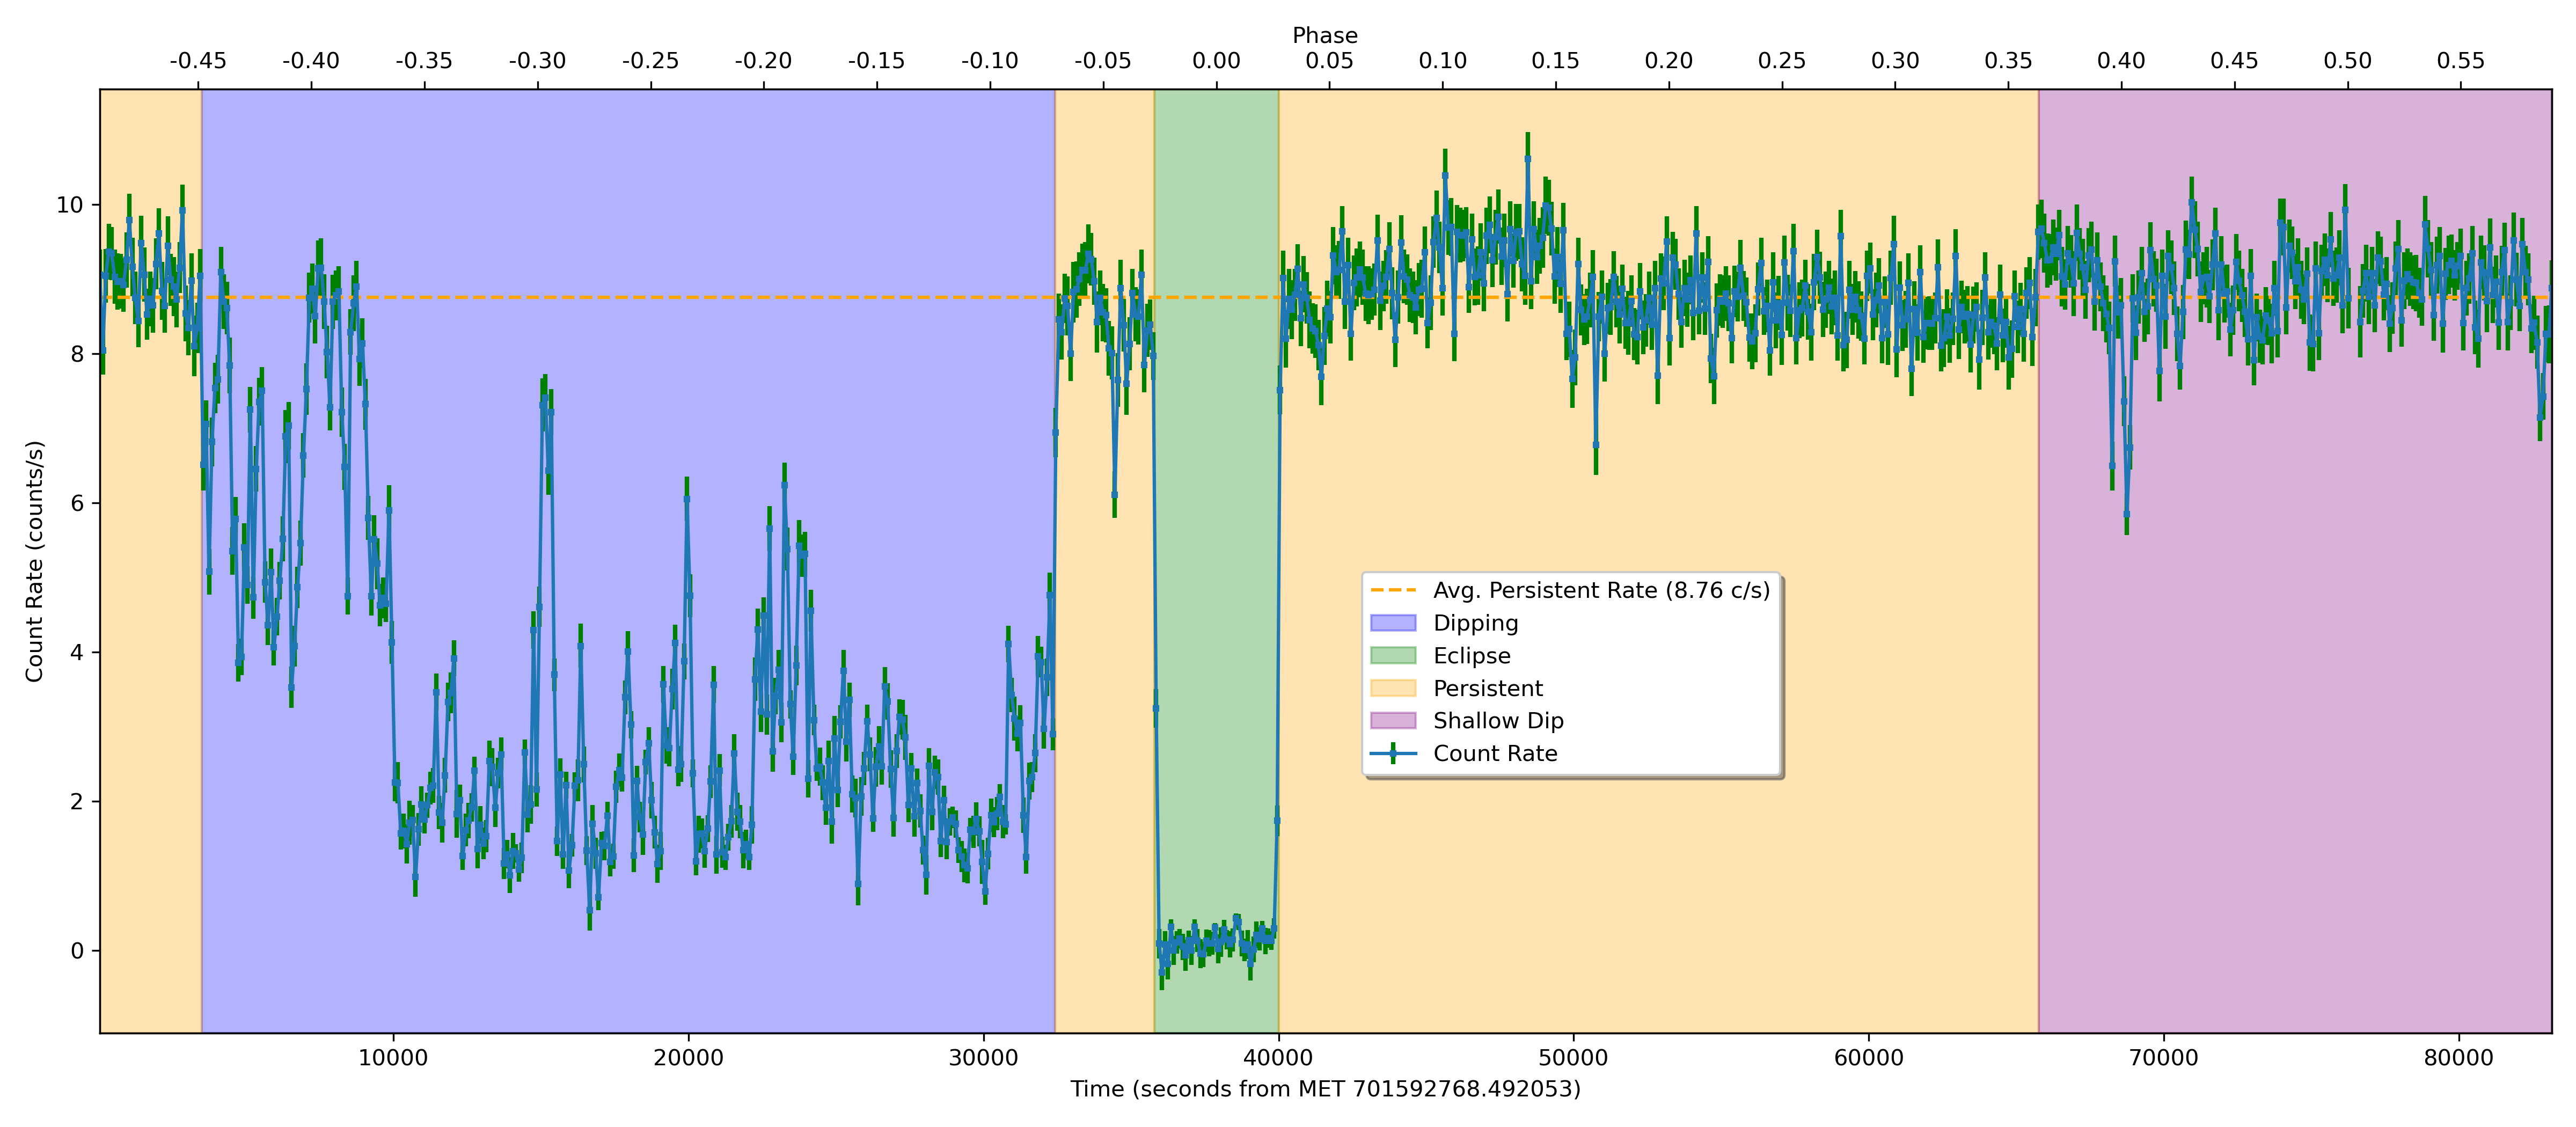

In [2]:
# Get Project Root and ObsID from the environment
os.environ['PROJECT_ROOT'] = '/media/kyle/kyle_phd/Swift-j1858.6-0814/'
os.environ['OBSID'] = '/0865600201'
project_root = os.environ.get('PROJECT_ROOT')
obsid = os.environ.get('OBSID')

# Define path to the corrected lightcurve
lc_file_path = f"{project_root}/products/{obsid}/pn/lc/pn_source_lc_corrected.fits"

# Read the RATE table to get time and rate columns
with fits.open(lc_file_path) as hdul:
    lc_table = Table(hdul[1].data)
# Extract time and rate
time = lc_table['TIME'] # This is in MET
rate = lc_table['RATE']

# Get the observation start time from the header
with fits.open(lc_file_path) as hdul:
    header = hdul[1].header
    tstart = header['TSTART'] # This is the MET start time
    tend = header['TSTOP']



# Convert time to relative seconds from the start of the observation
time_relative = (time - tstart)

# --- Define intervals based on visual inspection of the plot ---
persistent_intervals = [(time_relative[0], 3510), (32430, 35780), (40000, 65760)]
dipping_intervals = (3510, 32430)
eclipse_intervals = (35780, 40000)
shallow_dip_interval = (65760, time_relative[-1])

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(16, 7), dpi=100) # Standard inline size
ax1.errorbar(time_relative, rate, yerr=lc_table['ERROR'], fmt='s-', markersize=2, alpha=1, elinewidth=2, ecolor='green', label='Count Rate')
ax1.set_xlabel(f'Time (seconds from MET {tstart:f})')
ax1.set_ylabel('Count Rate (counts/s)')


# average count rate for persistent intervals
persistent_mask = ((time_relative >= persistent_intervals[0][0]) & (time_relative <= persistent_intervals[0][1])) | \
                  ((time_relative >= persistent_intervals[1][0]) & (time_relative <= persistent_intervals[1][1])) | \
                  ((time_relative >= persistent_intervals[2][0]) & (time_relative <= persistent_intervals[2][1]))
persistent_rate = rate[persistent_mask]
average_persistent_rate = persistent_rate.mean()
ax1.hlines(average_persistent_rate, time_relative[0], time_relative[-1], colors='orange', linestyles='dashed', label=f'Avg. Persistent Rate ({average_persistent_rate:.2f} c/s)')

# Highlight intervals
ax1.axvspan(dipping_intervals[0], dipping_intervals[1], color='blue', alpha=0.3, label='Dipping')
ax1.axvspan(eclipse_intervals[0], eclipse_intervals[1], color='green', alpha=0.3, label='Eclipse')
ax1.axvspan(persistent_intervals[0][0], persistent_intervals[0][1], color='orange', alpha=0.3, label='Persistent')
ax1.axvspan(persistent_intervals[1][0], persistent_intervals[1][1], color='orange', alpha=0.3)
ax1.axvspan(persistent_intervals[2][0], persistent_intervals[2][1], color='orange', alpha=0.3)
ax1.axvspan(shallow_dip_interval[0], shallow_dip_interval[1], color='purple', alpha=0.3, label='Shallow Dip')

ax1.legend(fancybox=True,shadow=True,loc='upper center', bbox_to_anchor=(0.6, 0.5))
ax1.set_xlim(time_relative[0], time_relative[-1])
#ax1.set_ylim(bottom=0) # Start y-axis at 0

# Add top axis for phase
ax2 = ax1.twiny() # create a second x-axis on top
period_seconds = 21.3 * 3600
t0 = (eclipse_intervals[0] + eclipse_intervals[1]) / 2  # Midpoint of the eclipse interval

def time_to_phase(t):
    return (t - t0) / period_seconds

ax2.set_xlabel("Phase")
# Get limits from ax1 and transform them for ax2
ax2.set_xlim(time_to_phase(ax1.get_xlim()[0]), time_to_phase(ax1.get_xlim()[1]))

ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('top')

# Set ticks at intervals of 0.05
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
ax2.xaxis.set_major_locator(MultipleLocator(0.05))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.tight_layout()
plt.close()

# Save the figure to the plots directory
plot_path = f"{project_root}/products/{obsid}/pn/lc/pn_states_lc.png"
fig.savefig(plot_path, dpi=300)
from IPython.display import Image, display
display(Image(filename=plot_path, width=800))


#### 5b. Convert Relative Times to Absolute Times

The intervals above are in relative seconds. The BASH script needs them in absolute MET seconds. This cell will use the tstart value from the FITS header to convert them and generate the expressions to be pasted into the script.

In [3]:
# --- 1. Persistent Filter ---
persistent_sas_strings = []
for interval in persistent_intervals:
    abs_start = tstart + interval[0]
    abs_end = tstart + interval[1]
    persistent_sas_strings.append(f"(TIME IN [{abs_start:f}:{abs_end:f}])")
persistent_filter = " && ".join(persistent_sas_strings)

# --- 2. Dipping Filter ---
dip_start = tstart + dipping_intervals[0]
dip_end = tstart + dipping_intervals[1]
dipping_filter = f"(TIME IN [{dip_start:f}:{dip_end:f}])"


# --- 3. Shallow Dip Filter ---
sha_start = tstart + shallow_dip_interval[0]
sha_end = tstart + shallow_dip_interval[1]
shallow_filter = f"(TIME IN [{sha_start:f}:{sha_end:f}])"



print("\n# OUTPUT_SUFFIXES array:")
print('OUTPUT_SUFFIXES=(\n'
      '    "Persistent"\n'
      '    "Dipping"\n'
      '    "Shallow"\n'
      ')')

print("\n# TIME_FILTERS array:")
print('TIME_FILTERS=(\n'
      f'    "{persistent_filter}"\n'
      f'    "{dipping_filter}"\n'
      f'    "{shallow_filter}"\n'
      ')')


# OUTPUT_SUFFIXES array:
OUTPUT_SUFFIXES=(
    "Persistent"
    "Dipping"
    "Shallow"
)

# TIME_FILTERS array:
TIME_FILTERS=(
    "(TIME IN [701592818.492053:701596278.492053]) && (TIME IN [701625198.492053:701628548.492053]) && (TIME IN [701632768.492053:701658528.492053])"
    "(TIME IN [701596278.492053:701625198.492053])"
    "(TIME IN [701658528.492053:701675918.492053])"
)


#### 5c. Manually Edit Script

I have now manually opened scripts/05_extract_time_spectra.sh and pasted the OUTPUT_SUFFIXES and TIME_FILTERS arrays printed in the cell above into the "USER CONFIGURATION" section.

#### 5d. Run Multi-Interval Extraction

Now that the script is configured with the correct time intervals, I will execute it. This will loop through all four states and extract a full set of spectral products for each one.

In [4]:
!../scripts/05_extract_time_spectra.sh > logs/05_extract_time_spectra.log 2>&1